In [2]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from Tools.backtest_tools import get_n_columns
from Tools.plotting import CandlePlot

In [3]:
data = pd.read_csv('../../DB/15m/INJUSDT_15m.csv')

In [4]:
BUY = 1
SELL = -1
NONE = 0
mult = 0.7
# Calculate the standard deviation for a 1000-window 
data['std_dev'] = data['close'].rolling(window=1000).std()
data['ma_band'] = data['close'].ewm(span=40, adjust=False).mean()
data['upper_band'] = data['ma_band'] + data['std_dev']  * mult
data['lower_band'] = data['ma_band'] - data['std_dev']  * mult

# Drop rows with NaN values
data = data.dropna()

dt = get_n_columns(data, ['close'], 1)


dt


,datetime,open,high,low,close,volume,quote_volume,std_dev,ma_band,upper_band,lower_band,n1_close
999,2022-12-01 13:00:00,1.734,1.744,1.730,1.743,0,0,0.070279,1.717159,1.766355,1.667964,NaN
1000,2022-12-01 13:15:00,1.743,1.744,1.727,1.737,0,0,0.070349,1.718127,1.767372,1.668883,1.743
1001,2022-12-01 13:30:00,1.737,1.737,1.722,1.723,0,0,0.070408,1.718365,1.767650,1.669080,1.737
1002,2022-12-01 13:45:00,1.723,1.723,1.692,1.707,0,0,0.070447,1.717811,1.767123,1.668498,1.723
1003,2022-12-01 14:00:00,1.707,1.716,1.702,1.711,0,0,0.070492,1.717478,1.766823,1.668134,1.707
...,...,...,...,...,...,...,...,...,...,...,...,...
62621,2024-09-03 10:30:00,16.790,16.810,16.703,16.720,0,0,2.057421,16.936742,18.376937,15.496547,16.790
62622,2024-09-03 10:45:00,16.720,16.748,16.648,16.748,0,0,2.056265,16.927535,18.366921,15.488149,16.720
62623,2024-09-03 11:00:00,16.748,16.794,16.708,16.771,0,0,2.055198,16.919899,18.358538,15.481261,16.748
62624,2024-09-03 11:15:00,16.771,16.805,16.751,16.805,0,0,2.054329,16.914294,18.352325,15.476264,16.771


In [5]:
def populate_signals(row):
    if row.close < row.upper_band and row.n1_close > row.upper_band:
        return BUY
    elif row.close > row.lower_band and row.n1_close < row.lower_band:
        return SELL
    return NONE

In [6]:
dt['signal'] = dt.apply(populate_signals, axis=1)

In [7]:
dt[dt['signal'] != NONE]

,datetime,open,high,low,close,volume,quote_volume,std_dev,ma_band,upper_band,lower_band,n1_close,signal
1230,2022-12-03 22:45:00,1.587,1.599,1.586,1.599,0,0,0.061039,1.636483,1.679210,1.593756,1.587,-1
2008,2022-12-12 01:15:00,1.615,1.623,1.615,1.623,0,0,0.025815,1.639565,1.657635,1.621494,1.615,-1
2026,2022-12-12 05:45:00,1.594,1.595,1.594,1.595,0,0,0.025965,1.612245,1.630421,1.594070,1.594,-1
2037,2022-12-12 08:30:00,1.584,1.586,1.583,1.585,0,0,0.026161,1.602799,1.621112,1.584486,1.584,-1
2079,2022-12-12 19:00:00,1.646,1.646,1.638,1.638,0,0,0.026158,1.624557,1.642867,1.606246,1.646,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61597,2024-08-23 18:30:00,21.747,21.758,21.522,21.550,0,0,0.839973,21.034241,21.622223,20.446260,21.747,1
61613,2024-08-23 22:30:00,22.203,22.222,22.070,22.072,0,0,0.924517,21.527113,22.174275,20.879952,22.203,1
61616,2024-08-23 23:15:00,22.308,22.310,22.171,22.225,0,0,0.942929,21.623824,22.283874,20.963774,22.308,1
62000,2024-08-27 23:15:00,18.931,19.089,18.873,19.081,0,0,1.536569,20.147197,21.222796,19.071598,18.931,-1


In [8]:
# Function to handle the closing of a trade
def close_trade(row, state):
    # Extract the state (trade status) and the relevant data from the row
    trade_open, entry_price, entry_signal = state['trade_open'], state['entry_price'], state['entry_signal']
    
    if not trade_open:
        # Open a new trade if no trade is currently open
        if row['signal'] == 1:
            state['entry_price'] = row['close']
            state['entry_signal'] = 1  # Buy trade
            state['trade_open'] = True
        elif row['signal'] == -1:
            state['entry_price'] = row['close']
            state['entry_signal'] = -1  # Sell trade
            state['trade_open'] = True
        return 0  # No closing action taken

    else:
        # Close a buy trade (when price goes above the moving average)
        if entry_signal == 1 and row['close'] > row['ma_band']:
            profit_loss = row['close'] - entry_price
            state['trade_open'] = False
            return profit_loss  # Return profit/loss on closing

        # Close a sell trade (when price goes below the moving average)
        elif entry_signal == -1 and row['close'] < row['ma_band']:
            profit_loss = entry_price - row['close']
            state['trade_open'] = False
            return profit_loss  # Return profit/loss on closing

    return 0  # No closing action taken yet

# Function to apply trade tracking across the DataFrame
def apply_trade_tracking(df):
    state = {
        'trade_open': False,  # Is there an open trade?
        'entry_price': 0,     # The price at which the trade was entered
        'entry_signal': 0     # Signal type: 1 for buy, -1 for sell
    }

    # Apply the close_trade function to each row
    df['profit_loss'] = df.apply(lambda row: close_trade(row, state), axis=1)

    # Filter rows with closed trades
    closed_trades_df = df[df['profit_loss'] != 0]
    return closed_trades_df

# Example usage
closed_trades_df = apply_trade_tracking(dt)
print(closed_trades_df)


                  datetime    open    high     low   close  volume  \
1231   2022-12-03 23:00:00   1.599   1.604   1.594   1.602       0   
2009   2022-12-12 01:30:00   1.623   1.627   1.621   1.626       0   
2038   2022-12-12 08:45:00   1.585   1.590   1.585   1.589       0   
2080   2022-12-12 19:15:00   1.638   1.639   1.635   1.639       0   
2095   2022-12-12 23:00:00   1.661   1.664   1.657   1.658       0   
...                    ...     ...     ...     ...     ...     ...   
61583  2024-08-23 15:00:00  20.921  21.109  20.855  21.014       0   
61598  2024-08-23 18:45:00  21.550  21.593  21.454  21.472       0   
61614  2024-08-23 22:45:00  22.072  22.174  22.014  22.126       0   
61617  2024-08-23 23:30:00  22.225  22.263  22.139  22.165       0   
62010  2024-08-28 01:45:00  18.676  18.814  18.573  18.777       0   

       quote_volume   std_dev    ma_band  upper_band  lower_band  n1_close  \
1231              0  0.061028   1.634801    1.677520    1.592081     1.599   
200

In [9]:
dt['profit_loss'] = dt['profit_loss'] * dt['signal']
def put_win_loss(x):
    if x > 0:
        return 'win'
    elif x<0:
        return 'loss'
    return 0
dt['label'] = dt['profit_loss'].apply(put_win_loss)

In [10]:

cp = CandlePlot(dt.iloc[0:2600])
cp.add_traces(['ma_band', 'upper_band', 'lower_band'])
cp.show_plot()


In [11]:
dt

,datetime,open,high,low,close,volume,quote_volume,std_dev,ma_band,upper_band,lower_band,n1_close,signal,profit_loss,label
999,2022-12-01 13:00:00,1.734,1.744,1.730,1.743,0,0,0.070279,1.717159,1.766355,1.667964,NaN,0,0.0,0
1000,2022-12-01 13:15:00,1.743,1.744,1.727,1.737,0,0,0.070349,1.718127,1.767372,1.668883,1.743,0,0.0,0
1001,2022-12-01 13:30:00,1.737,1.737,1.722,1.723,0,0,0.070408,1.718365,1.767650,1.669080,1.737,0,0.0,0
1002,2022-12-01 13:45:00,1.723,1.723,1.692,1.707,0,0,0.070447,1.717811,1.767123,1.668498,1.723,0,0.0,0
1003,2022-12-01 14:00:00,1.707,1.716,1.702,1.711,0,0,0.070492,1.717478,1.766823,1.668134,1.707,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62621,2024-09-03 10:30:00,16.790,16.810,16.703,16.720,0,0,2.057421,16.936742,18.376937,15.496547,16.790,0,0.0,0
62622,2024-09-03 10:45:00,16.720,16.748,16.648,16.748,0,0,2.056265,16.927535,18.366921,15.488149,16.720,0,0.0,0
62623,2024-09-03 11:00:00,16.748,16.794,16.708,16.771,0,0,2.055198,16.919899,18.358538,15.481261,16.748,0,0.0,0
62624,2024-09-03 11:15:00,16.771,16.805,16.751,16.805,0,0,2.054329,16.914294,18.352325,15.476264,16.771,0,0.0,0


In [12]:
# Define the features (X) and the target (y)
X = dt[['std_dev', 'upper_band', 'lower_band']]  # Features
y = dt['label']  # Target ('win' or 'loss')

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print(X_train.shape, X_test.shape)


(49301, 3) (12326, 3)


In [13]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)


Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12326

    accuracy                           1.00     12326
   macro avg       1.00      1.00      1.00     12326
weighted avg       1.00      1.00      1.00     12326



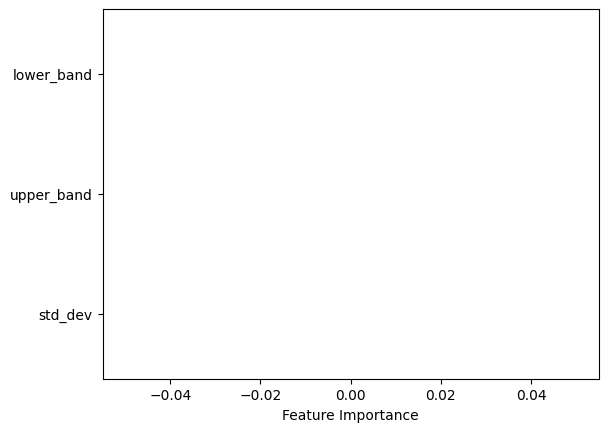

In [14]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print a classification report to see precision, recall, etc.
print(classification_report(y_test, y_pred))

# Optional: Plot feature importance
importances = rf_model.feature_importances_
feature_names = ['std_dev', 'upper_band', 'lower_band']
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.show()
